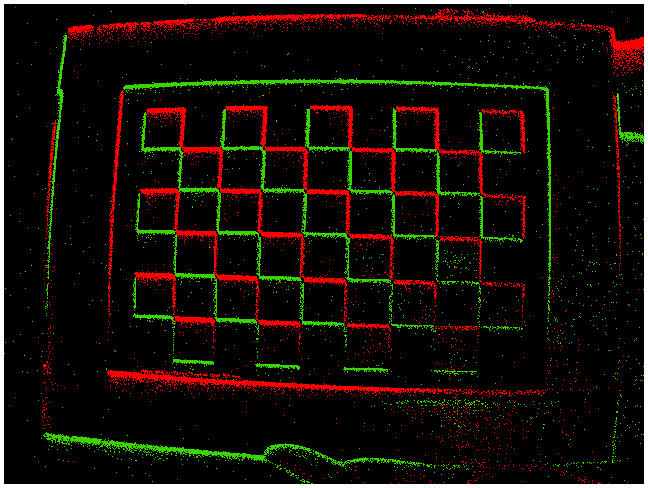

Parser took: 16 seconds.


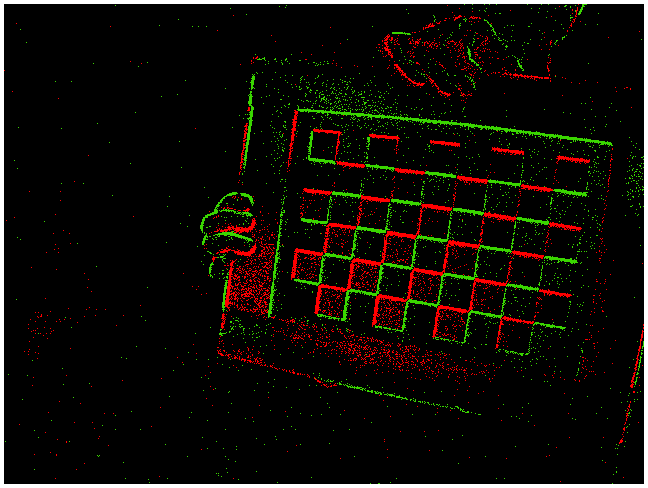

Parser took: 16 seconds.


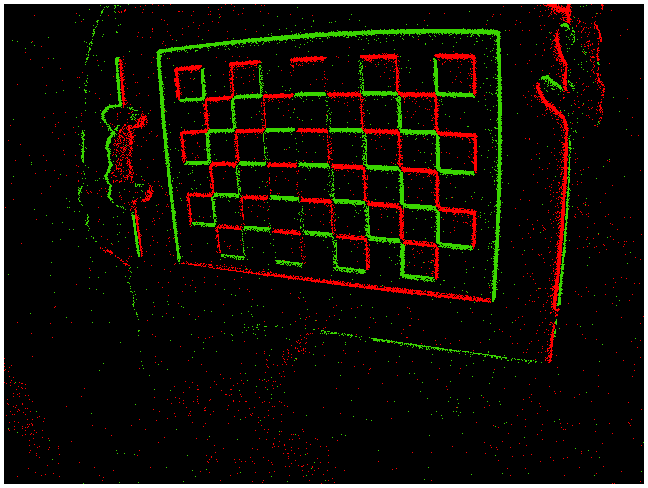

Parser took: 135 seconds.


In [1]:

%matplotlib inline


import sys, getopt
import pdb
import time
import cv2 as cv
import numpy as np
import pdb
import matplotlib.pyplot as plt

from dv import AedatFile
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#FF0001-000000-3BD600
    (0.000, (1.000, 0.000, 0.004)),
    (0.500, (0.000, 0.000, 0.000)),
    (1.000, (0.231, 0.839, 0.000))))

def getNextRow(inputfile):

    with AedatFile(inputfile) as ifile:
        # loop through the "events" stream
        for e in ifile["events"]:
            t = e.timestamp
            x = e.x
            y = e.y
            p = int(e.polarity)
            yield (t, x, y, p)

def preprocess(m):
    
    th_green = 1
    th_red = -th_green
    
    
    m[((m < th_green) & (m > th_red))] = 0
    m[m > th_green] = 1
    m[m < th_red] = -1    

    m += np.ones(m.shape, dtype=int)

    return m*128

def print_all(m):
    
    x,y = m.shape
    count_red = 0
    count_green = 0
    count_black = 0
    # print("[\n")
    for i in range(x):
        for j in range (y):
            if m[i,j] == 0:
                count_black += 1
            else:                
                # print("\t(%d,%d) : %d\n" %(i,j,m[i,j]))
                if m[i,j] < 0:
                    count_red += 1
                if m[i,j] > 0:
                    count_green += 1
    # print("]\n")
    
    print("# red: %d\n" %(count_red))
    print("# green: %d\n" %(count_green))
    print("# black: %d\n" %(count_black))

    
'''
This code produces 1 image out of events every 1/<fps>ms
Images are ignored when less than <activity>% of the pixels are inactive 
Among the used images, one will be stored after visual/manual inspection
The image to be stored needs to be evidently affected by lens distortion
The distorted image is necesary to check distortion maps
'''

if __name__ == "__main__":
    
    for i in range(3):
        camera_id = i+1
        my_dpi = 40
        x_max = 640
        y_max = 480
        fps = 60
        activity = 1
        if camera_id == 1:
            image_of_interest = 40 
        if camera_id == 2:
            image_of_interest = 40 
        if camera_id == 3:
            image_of_interest = 255 
        change_interval = int(1000/fps)*1000 # 33 ms : 30Hz  

        screen = np.zeros((x_max, y_max),dtype=int)

        inputfile = "recordings/rec_cam"+ str(camera_id) + ".aedat4"
        nb_events = -1 # Use all the events in the recording (if necessary)

        start = time.time()

        line_count = 0 # event counter
        image_counter = 0 # frame counter
        for t, x, y, p in getNextRow(inputfile):    


            # Extract time offset
            if line_count == 0 :
                first_t = t
                t_next_change = change_interval

            t_relative = t - first_t # first event occurs at t=0

            # Visualize Stuff and Prepare for next frame
            if t_relative > t_next_change:

                inactive_pixels = np.sum(screen == 0)
                if inactive_pixels < int((100-activity)/100*x_max*y_max):
                    if image_counter == image_of_interest-1:
                        screen = preprocess(screen)   
                        fig = plt.figure(figsize=(x_max/my_dpi, y_max/my_dpi), dpi=my_dpi, frameon=False)    
                        ax = plt.Axes(fig, [0., 0., 1., 1.])
                        ax.set_axis_off()
                        fig.add_axes(ax)
                        ax.imshow(np.transpose(screen), cmap=my_gradient, aspect='auto')
                        fig.savefig("images/distorted_" + str(camera_id) + ".png")
                        plt.pause(1)
                    image_counter += 1
                    if image_counter >= image_of_interest:
                        break

                # Clear window
                screen = np.zeros((x_max, y_max),dtype=int)
                t_next_change += change_interval

            else:
                screen[x,y] += 2*p-1


            line_count += 1

            # Check if enough events have been parsed
            if (nb_events > 0) and (line_count > nb_events):
                # Stop parsing since nb_events reached
                break

        stop = time.time()

        elapsed = stop - start
        print("Parser took: " + str(int(elapsed)) + " seconds.")